# Z:P ratio compared with nutrients

#### - Includes, phytoplankton & zooplankton biomass
#### - scatter plot included in documentation of global Z:P relationship which has similarities with Hatton et al. 2015

Here we want to understand if the Z:P is driven by nutrient concentrations, (more of a bottom-up) control. 
However, it seems that it is not driven by bottom-up controls and instead by the ecosystem. 

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs

import geoviews as gv
import holoviews as hv
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean
from scipy import stats
from scipy.stats import gaussian_kde

In [2]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [3]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result


In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [5]:
print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

What is the new file? (new_file)


 GNG595


What year? (year)


 20yrclim


In [15]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [16]:
## Jessica's Path 
jluo_path = '/glade/scratch/jluo/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## Gaby's Path 
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## 10 year climatology from year 53 - 62 representing Jan 2000-Dec 2009
new_path = '/glade/scratch/jluo/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

In [17]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009. 
newNCDFfiles = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_2ndcycle_20year_clim/clim_20yr_GNG595_*', recursive=True),
                      key=numericalSort)

ds= xr.open_mfdataset(newNCDFfiles,combine='by_coords')

# Phytoplankton

In [18]:
mmolcm3pm3s_to_gpy = 1e-6 * 1.2011e-2 * 86400 * 365
mmolcm2pm2s_to_gpy = 1e-4 * 1.2011e-2 * 86400 * 365
mmolcm2pm2_to_g = 1e-4 * 1.2011e-2

In [19]:
total_prim_prod = ds.photoC_TOT.sum(dim='z_t_150m') * 10 * ds.TAREA * mmolcm2pm2s_to_gpy

print(total_prim_prod.sum(dim=['nlat', 'nlon']).mean(dim='time').values)

5.14531557337071e+16


In [20]:
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'C' for v in phyto_names] # mmol C /m^3
phytoC = xr.concat([ds[v] for v in phyto_vars], dim='var').sum(dim='var') # units are mmol
phytoC_zint = phytoC.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

In [21]:
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'C' for v in phyto_names] # mmol C /m^3
phytoC_ind = xr.concat([ds[v] for v in phyto_vars], dim='var')
phytoC_ind_zint = phytoC_ind.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

### Add phytoplankton biomass threshold anything below 1.06 mmol C m-2 make zero 

In [22]:
mask_less_than_zero = phytoC_ind_zint.values < 1.065 # find all that are less than zero 
new_phytoC_ind_zint = phytoC_ind_zint.values
new_phytoC_ind_zint[mask_less_than_zero] = 0 # Make these values zero

In [23]:
x, y, zg_pp = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[0,:,:,:],axis=0))
x, y, zg_diaz = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[1,:,:,:],axis=0))
x, y, zg_mp1 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[2,:,:,:],axis=0))
x, y, zg_mp2 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[4,:,:,:],axis=0))
x, y, zg_mp3 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[6,:,:,:],axis=0))
x, y, zg_mp4 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[8,:,:,:],axis=0))
x, y, zg_diat1 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[3,:,:,:],axis=0))
x, y, zg_diat2 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[5,:,:,:],axis=0))
x, y, zg_diat3 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[7,:,:,:],axis=0))

### Plot phytoplankton biomass (log10, depth integrated over the top 100m)

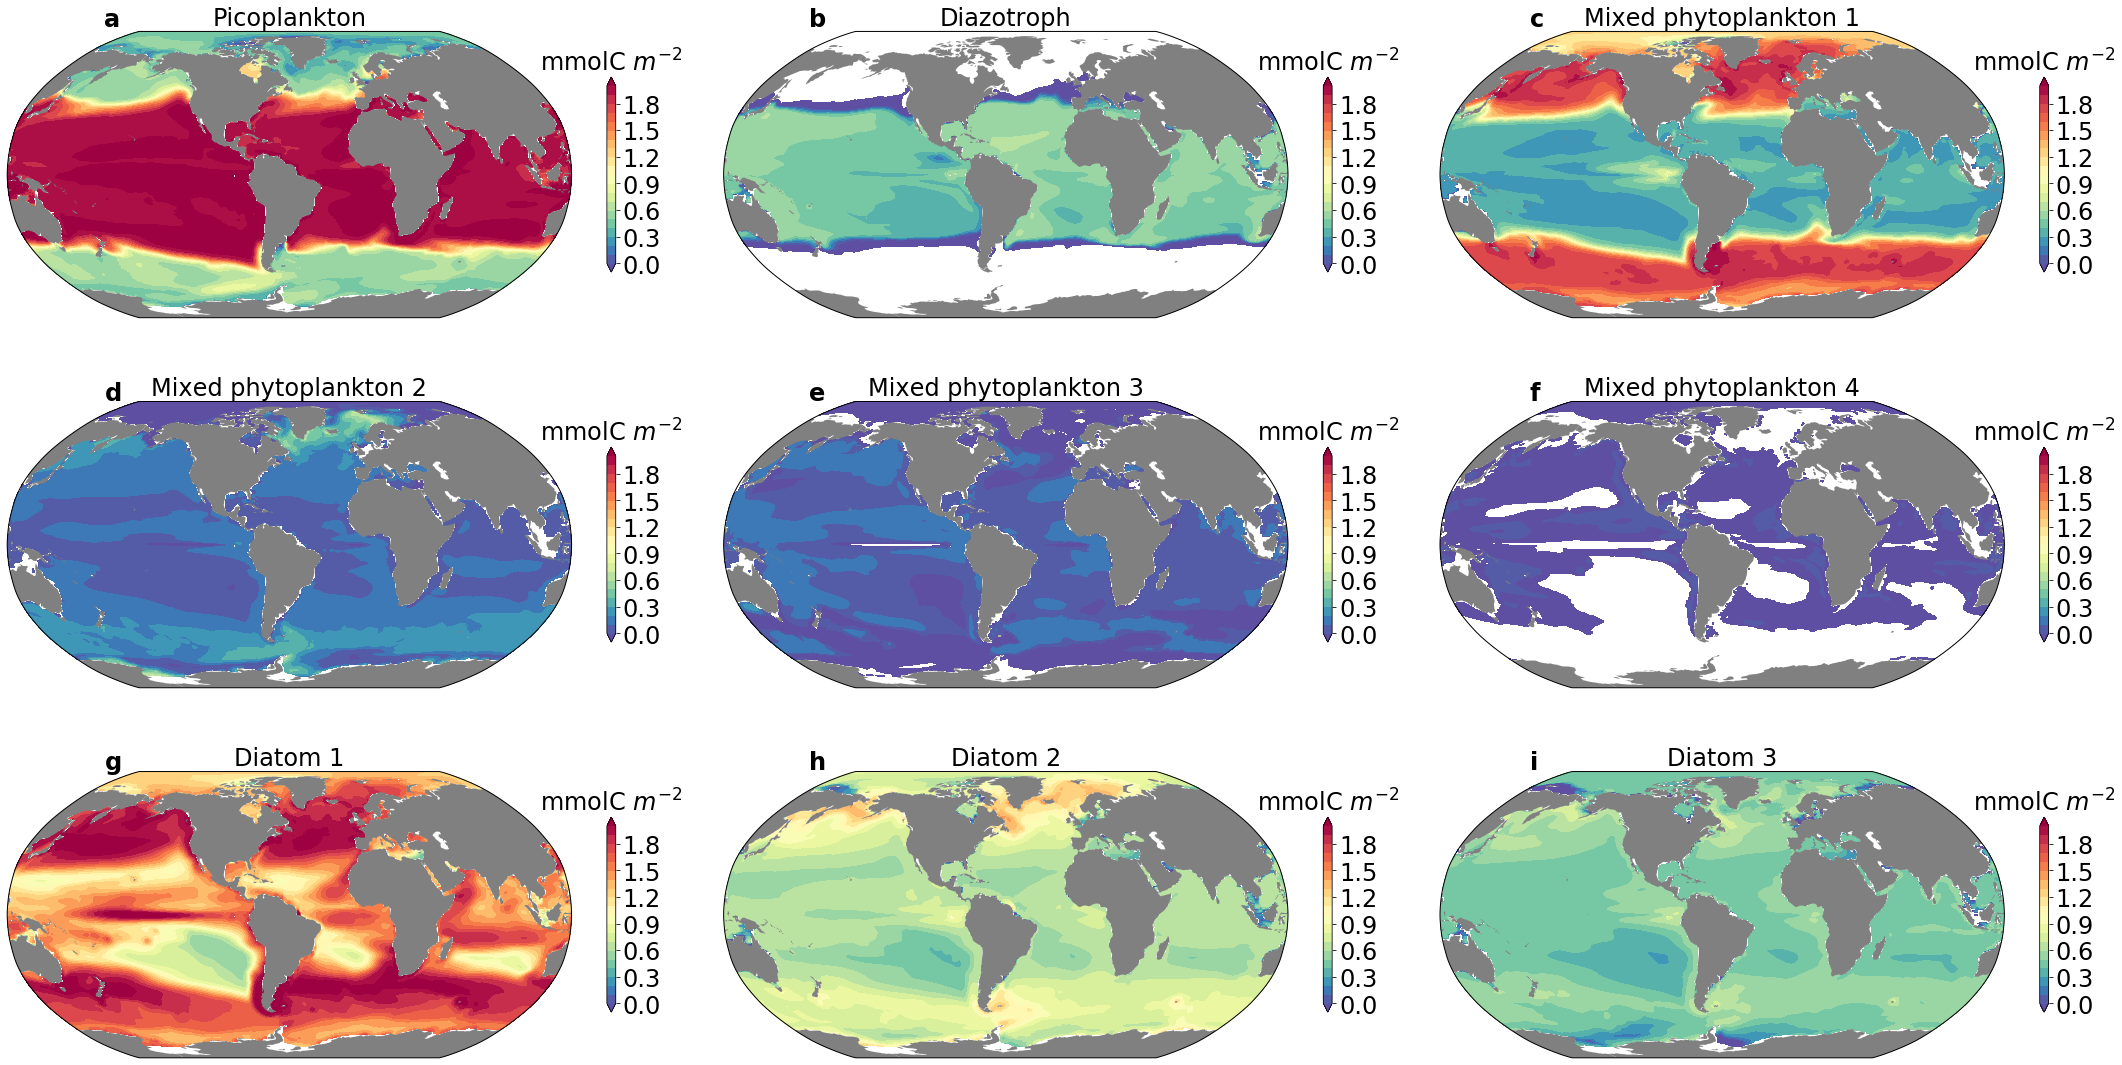

In [24]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(30, 16))
lev = np.arange(0, 2.1, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
ax = fig.add_subplot(3, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_pp), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
ax.set_global()
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Picoplankton', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.05, 0.95, 'a',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_diaz), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diazotroph', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.376, 0.95, 'b',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_mp1), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 1', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.71, 0.95, 'c',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_mp2), cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 2', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.05, 0.625, 'd',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_mp3), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 3', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.376, 0.625, 'e',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_mp4), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Mixed phytoplankton 4', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.71, 0.625, 'f',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 7, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_diat1), cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 1', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.05, 0.305, 'g',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 8, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_diat2), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 2', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.376, 0.305, 'h',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(3, 3, 9, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_diat3), cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Diatom 3', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.71, 0.305, 'i',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)
fig.tight_layout()
plt.show()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/phyto_biomass_'+new_file+'.png',dpi=600, bbox_inches='tight')

## Phytoplankton biomass in small, medium or large categories! 

In [25]:
pp1 = zg_pp + zg_mp1
mp1 = zg_mp3 + zg_mp4+ zg_diat3+ zg_diat2
np1 = zg_diat1 +  zg_mp2+ zg_diaz

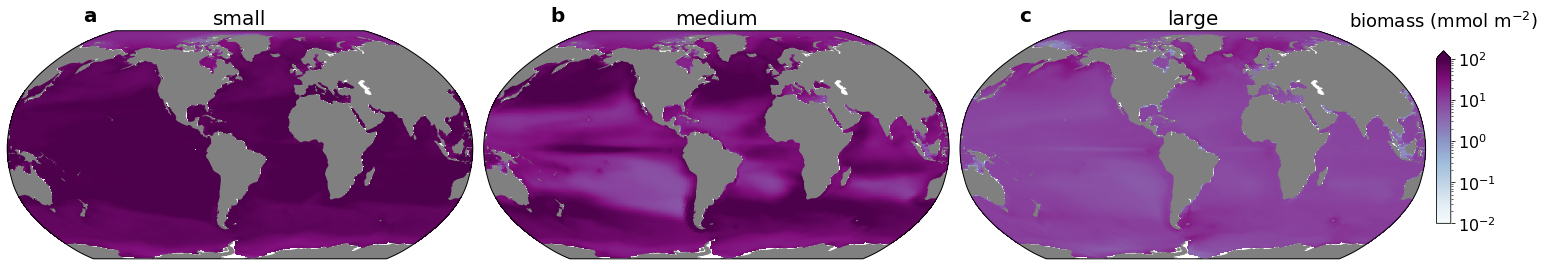

In [26]:
lev = np.arange(0,100,1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolormesh(x, y, mp1, norm=colors.LogNorm(vmin=0.01, vmax=100),cmap='BuPu', shading='auto',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('large', fontsize=20);
fig.text(0.385, 0.95, 'b',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolormesh(x, y, np1, norm=colors.LogNorm(vmin=0.01, vmax=100),cmap='BuPu', shading='auto',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('medium', fontsize=20);
fig.text(0.06, 0.95, 'a',fontsize=20, fontweight='bold')

ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolormesh(x, y, pp1, norm=colors.LogNorm(vmin=0.01, vmax=100),cmap='BuPu', shading='auto',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('small', fontsize=20);
fig.text(0.71, 0.95, 'c',fontsize=20, fontweight='bold')

cb_ax = fig.add_axes([1, 0.6, 0.01, 0.3])
cbar = fig.colorbar(cf, extend='max', cax=cb_ax, shrink=0.5)
cbar.ax.set_title('biomass (mmol m$^{-2}$)', fontsize = 18, y=1.25, pad=-20)
cbar.ax.tick_params(labelsize=16)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/biomass_phytoplankton.png',dpi=600, bbox_inches='tight')

# Zooplankton

In [27]:
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
zoo_vars = [''+v+'C' for v in zoo_names] # mmol C /m^3
zoo_ind = xr.concat([ds[v] for v in zoo_vars], dim='var')
zoo_ind_zint = zoo_ind.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

### Add same threshold to zooplankton

In [28]:
mask_less_than_zero = zoo_ind_zint.values < 1.065 # find all that are less than zero 
new_zoo_ind_zint = zoo_ind_zint.values
new_zoo_ind_zint[mask_less_than_zero] = 0 # Make these values zero

In [29]:
x, y, zg_zoo1 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[0,:,:,:],axis=0))
x, y, zg_zoo2 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[1,:,:,:],axis=0))
x, y, zg_zoo3 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[2,:,:,:],axis=0))
x, y, zg_zoo4 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[3,:,:,:],axis=0))
x, y, zg_zoo5 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[4,:,:,:],axis=0))
x, y, zg_zoo6 = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[5,:,:,:],axis=0))

### Plot zooplankton biomass (log10, depth integrated over the top 100m)

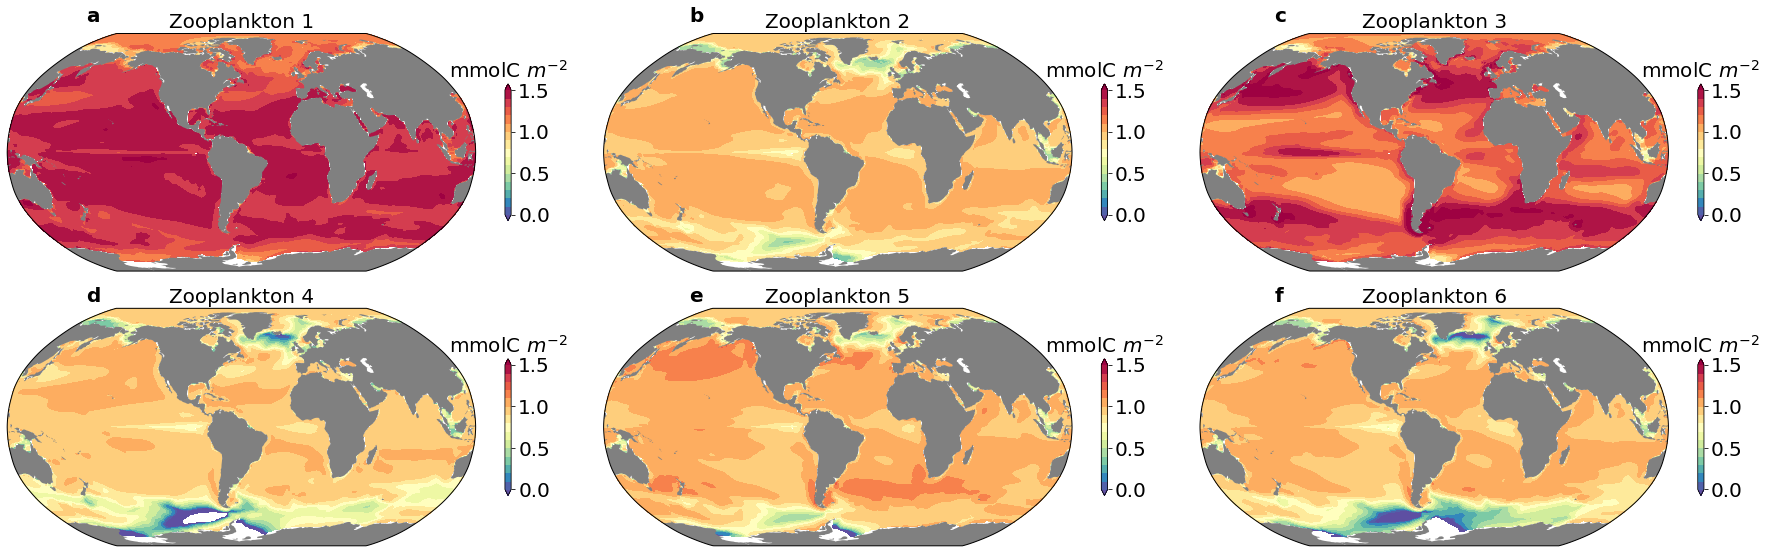

In [19]:
fig = plt.figure(figsize=(25, 8))
lev = np.arange(0, 1.51, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.75)
ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_zoo1), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 1', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 20)
fig.text(0.05, 0.96, 'a',fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.contourf(x, y, np.log10(zg_zoo2), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 2', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 20)
fig.text(0.385, 0.96, 'b',fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_zoo3), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 3', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 20)
fig.text(0.71, 0.96, 'c',fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_zoo4), cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 4', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 20)
fig.text(0.05, 0.475, 'd',fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(2, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_zoo5), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 5', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 20)
fig.text(0.385, 0.475, 'e',fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=20)

ax = fig.add_subplot(2, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, np.log10(zg_zoo6), cmap='Spectral_r', levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('Zooplankton 6', fontsize = 20)
cbar = plt.colorbar(cf,ticks = [0,0.5,1,1.5],shrink =0.5,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 20)
fig.text(0.71, 0.475, 'f',fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=20)

fig.tight_layout()
plt.show()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/zoo_biomass_'+new_file+'.png',dpi=600, bbox_inches='tight')

### Zooplankton Production and Biomass

In [30]:
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
zoo_vars = ['x_graze_'+v+'_zint' for v in zoo_names]
zooProd_TOT = xr.concat([ds[v] for v in zoo_vars], dim='var').sum(dim='var') # units are mmol m-3 * cm s-1
zooProd_TOT = ((zooProd_TOT / 100) * ds.TAREA / 1e4).sum(dim=['nlat','nlon'])
zooProd_TOT = zooProd_TOT.mean(dim='time') * (60*60*24*365) # mmol y-1
zooProd_TOT = zooProd_TOT * 12.011 /1e3 # g C y-1
print(np.format_float_scientific(zooProd_TOT.values,2))

1.21e+16


In [31]:
zoo_var_names = ['zoo1', 'zoo2','zoo3', 'zoo4', 'zoo5', 'zoo6']
total_zoo_prod = xr.concat([ds['x_graze_' + v + '_zint'] for v in zoo_var_names], dim='var').sum(dim='var') * ds.TAREA * mmolcm3pm3s_to_gpy # mmol/m^3 cm/s to g C yr-1

zooC = xr.concat([ds[v+'C'] for v in zoo_var_names], dim='var').sum(dim='var')
zooC_zint = zooC.sum(dim='z_t_150m') * 10

## Adding threshold once again

In [32]:
mask_less_than_zero = zooC_zint.values < 1.065 # find all that are less than zero 
new_zooC_zint = zooC_zint.values
new_zooC_zint[mask_less_than_zero] = 0 # Make these values zero

### Sum up all of the phytoplankton biomass

In [33]:
new_phytoC_zint = np.sum(new_phytoC_ind_zint,axis=0)

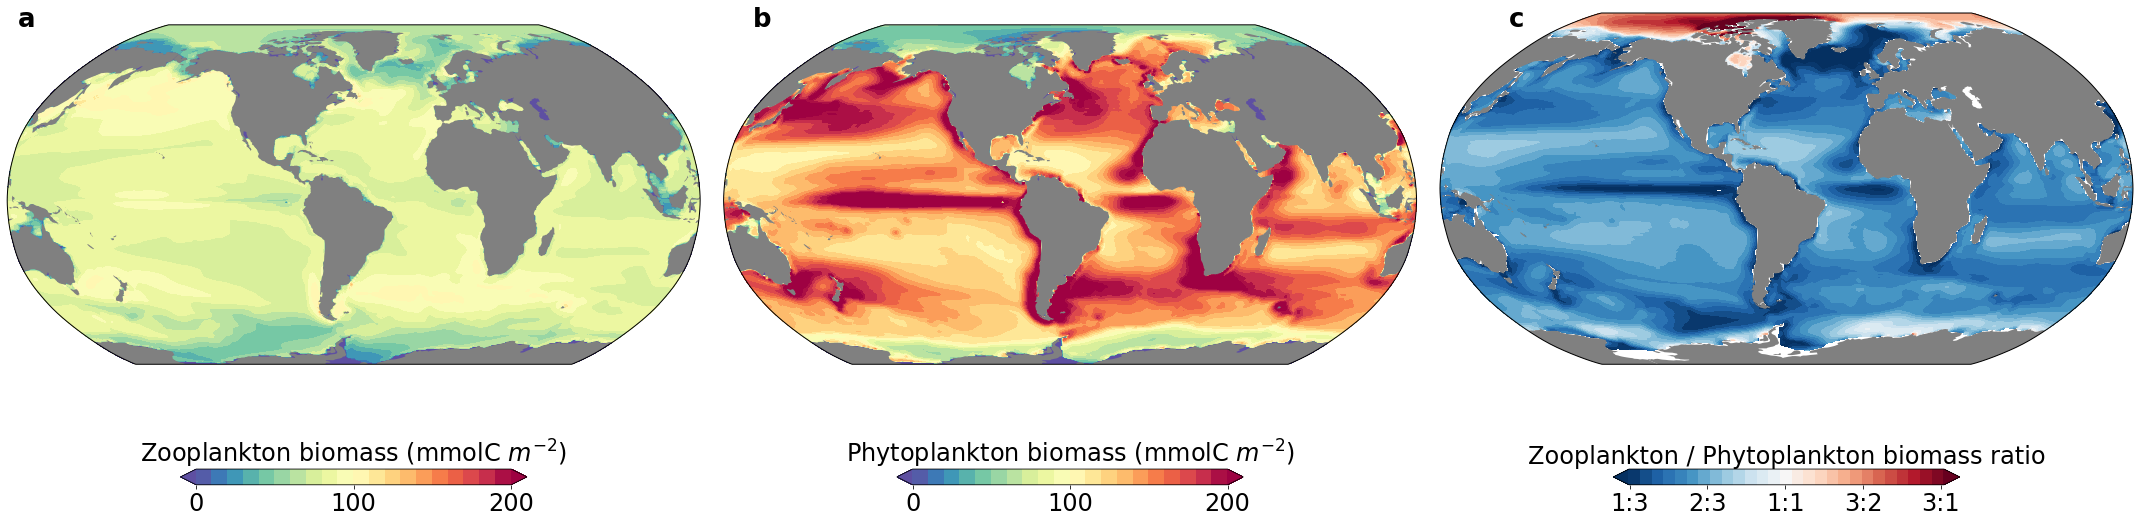

In [24]:
fig = plt.figure(figsize=(30, 10))

lev = np.arange(0, 201, 10)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=100)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zooC_zint,axis=0))
ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,100,200],shrink=0.5, orientation='horizontal')
cb.ax.set_title('Zooplankton biomass (mmolC $m^{-2}$)', fontsize = 24)
cb.ax.tick_params(labelsize=24)


lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_zint,axis=0))
ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0,100,200],shrink=0.5, orientation='horizontal')
cb.ax.set_title('Phytoplankton biomass (mmolC $m^{-2}$)', fontsize = 24)
cb.ax.tick_params(labelsize=24)


lev = np.arange(0.33, 1.7, 0.05)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
levels = [1]
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zooC_zint,axis=0)/np.mean(new_phytoC_zint,axis=0))
ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='RdBu_r',vmin = 0.33, vmax=1.7,levels = lev,norm=norm,extend='both', transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[0.333,0.666,1,1.333,1.666],shrink=0.5, orientation='horizontal')
cb.ax.set_xticklabels(['1:3','2:3','1:1','3:2','3:1'])
cb.ax.set_title('Zooplankton / Phytoplankton biomass ratio', fontsize = 24)
cb.ax.tick_params(labelsize=24)
fig.text(0.01, 0.775, 'a',fontsize=26, fontweight='bold')
fig.text(0.35, 0.775, 'b',fontsize=26, fontweight='bold')
fig.text(0.7, 0.775, 'c',fontsize=26, fontweight='bold')
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/biomass_ZPratio_'+new_file+'.png',dpi=600, bbox_inches='tight')

In [34]:
ZP_ratio = np.mean(new_zooC_zint,axis=0)/np.mean(new_phytoC_zint,axis=0)
P_biomass = np.mean(new_phytoC_zint,axis=0)
Z_biomass = np.mean(new_zooC_zint,axis=0)

## Compare phytoplankton production with phytoplankton biomass for each phytoplankton type

In [35]:
## Production 
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = ['photoC_'+v+'_zint' for v in phyto_names]
phytoProd = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol m-3 * cm s-1
phytoProd = ((phytoProd / 100)) * (60*60*24*365) *12.011 /1e3#  # g C y-1 m-2

In [36]:
## Biomass
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'C' for v in phyto_names] # mmol C /m^3
phytoC_ind = xr.concat([ds[v] for v in phyto_vars], dim='var')
phytoC_ind_zint = phytoC_ind.sum(dim='z_t_150m') * 10 *12.011 /1e3 #integrate over depth #gC C m-2

#mask_less_than_zero = phytoC_ind_zint.values < 1.065 # find all that are less than zero 
#new_phytoC_ind_zint = phytoC_ind_zint.values
#new_phytoC_ind_zint[mask_less_than_zero] = 0 # Make these values zero

## Zooplankton production vs biomass

In [37]:
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
zoo_vars = ['x_graze_'+v+'_zint' for v in zoo_names]
zooProd_TOT = xr.concat([ds[v] for v in zoo_vars], dim='var') # units are mmol m-3 * cm s-1
zooProd_TOT = ((zooProd_TOT / 100))
zooProd_TOT = zooProd_TOT * (60*60*24*365) # mmol m-2 y-1
zooProd_TOT = zooProd_TOT * 12.011 /1e3 # g C m-2 y-1

In [38]:
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
zoo_vars = [''+v+'C' for v in zoo_names] # mmol C /m^3
zoo_ind = xr.concat([ds[v] for v in zoo_vars], dim='var')
zoo_ind_zint = zoo_ind.sum(dim='z_t_150m') * 10 * 12.011 /1e3 #integrate over depth #g C m-2

#mask_less_than_zero = zoo_ind_zint.values < 1.065 # find all that are less than zero 
#new_zoo_ind_zint = zoo_ind_zint.values
#new_zoo_ind_zint[mask_less_than_zero] = 0 # Make these values zero

## Example to plot CI 

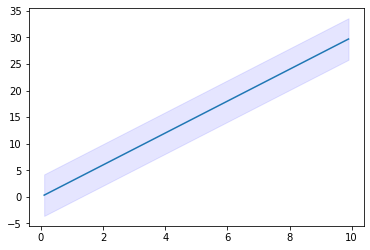

In [39]:
from matplotlib import pyplot as plt
import numpy as np

#some example data
x = np.linspace(0.1, 9.9, 20)
y = 3.0 * x
#some confidence interval
ci = 1.96 * np.std(y)/np.sqrt(len(x))

fig, ax = plt.subplots()
ax.plot(x,y)
ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

In [40]:
XX = np.log10(np.mean(phytoC_ind_zint,axis=(0,1))+1)
YY = np.log10(np.mean(zoo_ind_zint,axis=(0,1))+1)

X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

res = stats.linregress(X, Y)

In [41]:
xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)

In [42]:
res

LinregressResult(slope=0.7463922636980466, intercept=0.005071159361829655, rvalue=0.9362995486917689, pvalue=0.0, stderr=0.0007986799370077947)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

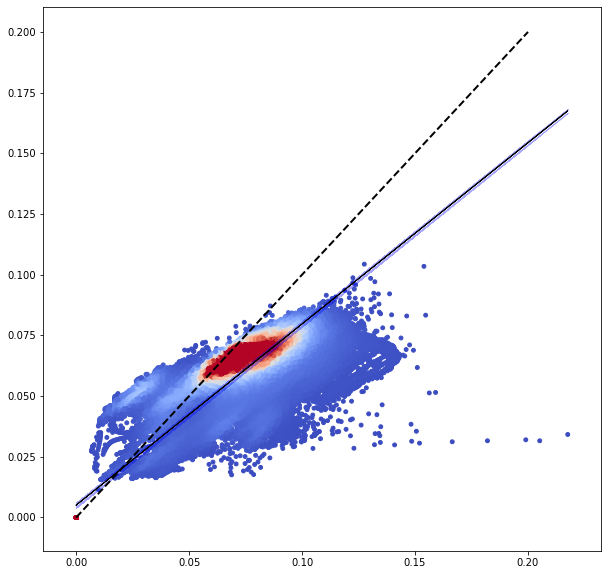

In [38]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

XX = np.log10(np.mean(phytoC_ind_zint,axis=(0,1))+1)
YY = np.log10(np.mean(zoo_ind_zint,axis=(0,1))+1)

X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

res = stats.linregress(X, Y)

xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)
plt.scatter(y=Y,x=X, c=z,s=15, alpha=1,cmap='coolwarm', vmin=0,vmax=700)
YYY = res.intercept + res.slope*XX
x_line = np.array(XX).flatten()
y_line = np.array(YYY).flatten()
plt.plot(x_line, y_line, 'k', linewidth = 1, label='fitted line')
plt.plot([0, 0.2], [0, 0.2],'--', linewidth=2,color='black')
plt.fill_between(x_line, (y_line-res.stderr), (y_line+res.stderr), color='b', alpha=.35)
equation = 'k =' + str(round(res.slope,4) +'$\u00B1$ 0.0007')
plt.text(0.15,0.1, equation, fontsize=20)
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('log$_{10}$ Phytoplankton Biomass (gC $m^{-2}$)', fontsize=25)
plt.ylabel('log$_{10}$ Zooplankton Biomass (gC $m^{-2}$)',fontsize = 25)

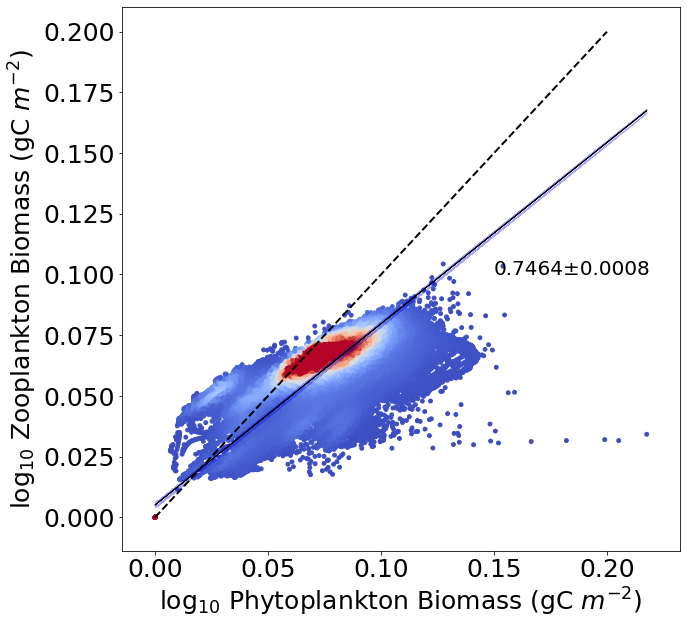

In [47]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

XX = np.log10(np.mean(phytoC_ind_zint,axis=(0,1))+1)
YY = np.log10(np.mean(zoo_ind_zint,axis=(0,1))+1)

X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

res = stats.linregress(X, Y)

xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)
plt.scatter(y=Y,x=X, c=z,s=15, alpha=1,cmap='coolwarm', vmin=0,vmax=700)
YYY = res.intercept + res.slope*XX
#plt.plot(XX, YYY, 'k', linewidth = 3, label='fitted line')
plt.plot(np.array(XX).flatten(), np.array(YYY).flatten(), 'k', linewidth = 1, label='fitted line')
plt.plot([0, 0.2], [0, 0.2],'--', linewidth=2,color='black')
plt.fill_between(np.array(XX).flatten(), (np.array(YYY).flatten()-res.stderr), (np.array(YYY).flatten()+res.stderr), color='b', alpha=.35)
#equation = 'y = ' + str(round(res.slope,4)) + 'x' ' + ' + str(round(res.intercept,4))
equation = '' + str(round(res.slope,4))+'\u00B1'+str(round(res.stderr,4))
plt.text(0.15,0.1, equation, fontsize=20)
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('log$_{10}$ Phytoplankton Biomass (gC $m^{-2}$)', fontsize=25)
plt.ylabel('log$_{10}$ Zooplankton Biomass (gC $m^{-2}$)',fontsize = 25)
f.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/mean_ZP_bmss_log10_'+new_file+'_'+year+'_year.png',dpi=300, bbox_inches='tight')

In [44]:
res

LinregressResult(slope=0.7463922636980466, intercept=0.005071159361829655, rvalue=0.9362995486917689, pvalue=0.0, stderr=0.0007986799370077947)

In [45]:
res.slope

0.7463922636980466

In [46]:
res.stderr

0.0007986799370077947

In [34]:
P_biomass[P_biomass ==0] = np.nan
Z_biomass[Z_biomass ==0] = np.nan

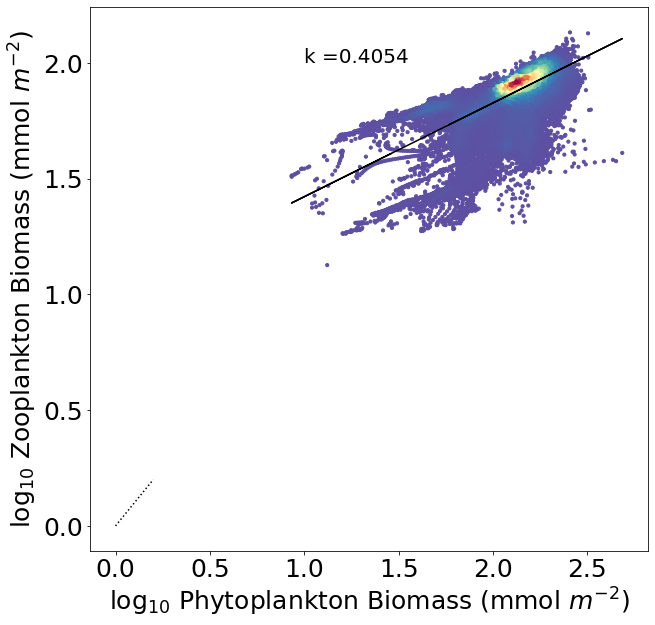

In [35]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

XX = P_biomass
YY = Z_biomass

X=np.array(XX)[~np.isnan(XX)& ~np.isnan(YY)]
Y=np.array(YY)[~np.isnan(XX)& ~np.isnan(YY)]

res = stats.linregress(np.log10(X).flatten(), np.log10(Y).flatten())

xy = np.vstack([np.log10(X),np.log10(Y)])
z = gaussian_kde(xy)(xy)
plt.scatter(y=np.log10(Y),x=np.log10(X), c=z,s=10, alpha=1,cmap='Spectral_r')

plt.plot(np.log10(X), res.intercept + res.slope*np.log10(X), 'k', label='fitted line')
plt.plot([0, 0.2], [0, 0.2],':', color='black')
#equation = 'y = ' + str(round(res.slope,4)) + 'x' ' + ' + str(round(res.intercept,4))
equation = 'k =' + str(round(res.slope,4))
plt.text(1,2, equation, fontsize=20)
    
plt.yticks(fontsize= 25 );
plt.xticks(fontsize= 25 );
plt.xlabel('log$_{10}$ Phytoplankton Biomass (mmol $m^{-2}$)', fontsize=25)
plt.ylabel('log$_{10}$ Zooplankton Biomass (mmol $m^{-2}$)',fontsize = 25)
f.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/ZP_bmss_log10_0_are_nan'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')